In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from attrbench.functional import deletion,insertion,infidelity, deletion_until_flip, sensitivity_n, impact_score
from attrbench.functional import max_sensitivity
from attrbench.lib import PixelMaskingPolicy, FeatureMaskingPolicy
from experiments.general_imaging.dataset_models import get_dataset_model
from experiments.lib import get_methods
import yaml
from experiments.test.util import AttributionWriter

In [10]:
## start tensorboard
%load_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...

# Initialization and parameters

In [11]:
BATCH_SIZE = 2
DATASET = "CIFAR10"
METHOD = "InputXGradient"

In [3]:
############################
# get model and method
############################
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset, model, sample_shape = get_dataset_model(DATASET)
methods = get_methods(model, aggregation_fn="avg", normalize=True, methods=[METHOD],
                      batch_size=BATCH_SIZE, sample_shape=sample_shape[-2:])
method = methods[METHOD]
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

## used for denormalizing
if DATASET == "ImageNette":
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
elif DATASET == "MNIST":
    mean=(0.1307,)
    std=(0.3081,)
elif DATASET == 'CIFAR10':
    mean=(0.4914, 0.4821, 0.4465)
    std=(0.2023, 0.1994, 0.2010)
# or scale image to [0,1] instead:
# mean=None
# std=None

Files already downloaded and verified


In [4]:
batch, labels = next(iter(DataLoader(dataset, BATCH_SIZE, num_workers=4, shuffle=True)))
batch = batch.to(device)
labels = labels.to(device)

# run metrics

In [5]:
############################
# metrics settings
############################
N_PERTURBATIONS = 16
mask_range = list(np.rint(np.linspace(0, 1, 5) * np.product(sample_shape)).astype(np.int))
pert_range = list(np.linspace(0.1, 2., 20))
masking_policy = PixelMaskingPolicy(0.) #FeatureMaskingPolicy(0.)
del_until_flip_step_size = 0.1 # .01

In [6]:
sum_writer = AttributionWriter('runs/Deletion',mean=mean, std=std)
deletion(batch, labels, model, method, mask_range, masking_policy,debug_mode=True, writer=sum_writer)
sum_writer.close()

C:\Users\axelj\Anaconda3\envs\Benchmarking\lib\site-packages\captum\_utils\gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [8]:
sum_writer = AttributionWriter('runs/Insertion',mean=mean, std=std)
insertion(batch, labels, model, method, mask_range, masking_policy,debug_mode=True, writer=sum_writer)
sum_writer.close()

In [14]:
sum_writer = AttributionWriter('runs/Infidelity',mean=mean, std=std)
infidelity(batch, labels, model, method, pert_range, N_PERTURBATIONS, debug_mode=True, writer=sum_writer)
sum_writer.close()

KeyboardInterrupt: 

In [11]:
sum_writer = AttributionWriter('runs/deletion_until_flip',mean=mean, std=std)
deletion_until_flip(batch, labels, model, method, del_until_flip_step_size,
                    masking_policy,debug_mode=True, writer=sum_writer)

sum_writer.close()

C:\Users\axelj\Anaconda3\envs\Benchmarking\lib\site-packages\captum\_utils\gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [ ]:
strict = False
tau = 0.5
sum_writer = AttributionWriter('runs/ImpactScore',mean=mean, std=std)
impact_score(batch, labels, model, method, mask_range, strict, masking_policy, tau, debug_mode=True, writer=sum_writer)
sum_writer.close()

In [ ]:
sum_writer = AttributionWriter('runs/MaxSensitivity',mean=mean, std=std)
max_sensitivity(batch,labels,method,mask_range, N_PERTURBATIONS,debug_mode=True, writer=sum_writer)
sum_writer.close()

C:\Users\axelj\Anaconda3\envs\Benchmarking\lib\site-packages\captum\_utils\gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


KeyboardInterrupt: 

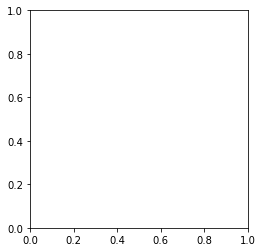

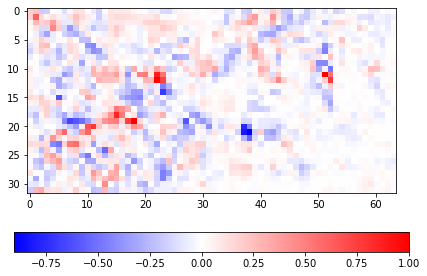

In [9]:
sum_writer = AttributionWriter('runs/SensitivityN',mean=mean, std=std)
sensitivity_n(batch,labels,model,method,mask_range[1:],N_PERTURBATIONS,masking_policy,
              debug_mode=True, writer=sum_writer)
sum_writer.close()